# Two layers

Quite simply (hopefully) increasing the number of layers.

I'll need to mess with my plotting to visualise all of the transforms.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
# seed = np.random.randint(1, 2**32 - 1)  # now starting to search through the seeds again
seed = 3375707384
set_all_seeds(seed)
print(seed)

3375707384


`3530314837`, `3375707384` - these looks pretty optimal

## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(2, dim, use_act=use_act),
            LinearLayer(dim, dim, use_act=use_act),  # have added this little guy
            LinearLayer(dim, 1, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

Going to sample $x_1$ (mass) and $x_2$ (acceleration) such that their product is uniformly distributed.

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

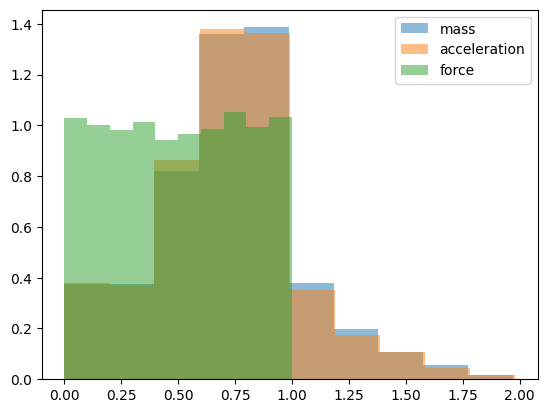

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [7]:
N = 4000  # number of epochs

model = Net(use_act=True, dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [8]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

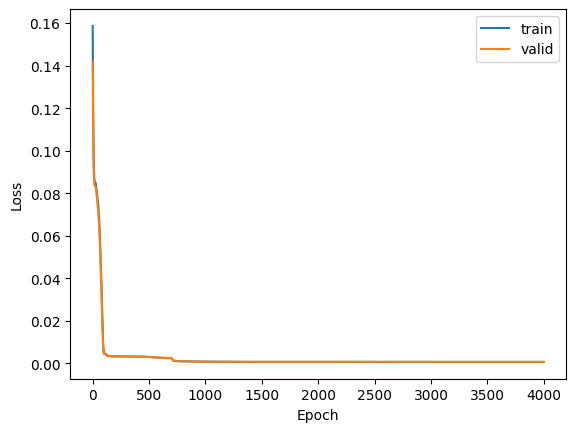

In [9]:
plot_loss(df["train_loss"], df["valid_loss"])

In [10]:
y_preds, y_targs = get_preds(model)

In [11]:
get_valid_loss(model, loss_func)

tensor(0.0007)

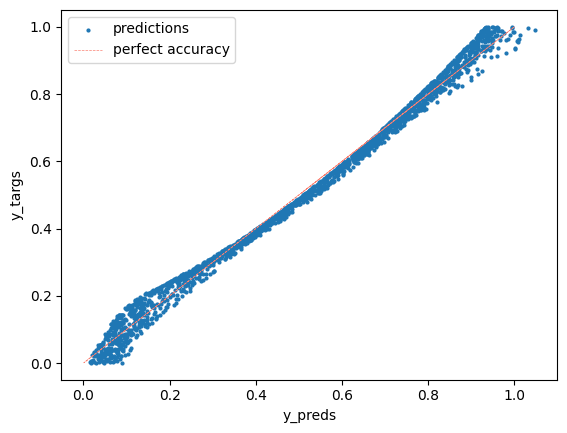

In [12]:
plot_results(y_preds, y_targs)

## Introspection

In [13]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [14]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[ 0.8494,  0.8565],
        [-0.8105,  1.0751]]) 

layers.0.linear.bias 
 tensor([-0.7922,  1.0284]) 

layers.1.linear.weight 
 tensor([[ 1.7057, -0.3792],
        [ 0.0912, -0.5713]]) 

layers.1.linear.bias 
 tensor([0.7447, 0.6570]) 

layers.2.linear.weight 
 tensor([[ 0.5314, -0.6904]]) 

layers.2.linear.bias 
 tensor([0.0176]) 



### Inspect intermediate values

Ok, at this stage, I really need to clean up my layer naming 😅

I think the convention I'll use is that the layer name in the `state_dict` is going to represent the _activations_ or more accurately just outputs **after** that parameter was applied.

`0.linear.weight` is going to be the inputs after they've simply gone into the initial weight matrix.

In [15]:
SD = model.state_dict()

In [16]:
from collections import OrderedDict
import torch
import torch.nn as nn


def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(module, input, output, name)
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2}
    return filtered_values


# a function that uses capture_intermediate_outputs to give a nice printed summary of the model outputs and parameters
def print_model_summary(model, input_tensor):
    intermediate_values = capture_intermediate_outputs(model, input_tensor)

    for k, v in intermediate_values.items():
        print(f"{k}: {v}")

In [17]:
print_model_summary(model, X_valid[0])

layers.0.linear.weight: tensor([ 1.2288, -0.0078])
layers.0.linear.bias: tensor([0.4366, 1.0206])
layers.0.act: tensor([0.4366, 1.0206])
layers.1.linear.weight: tensor([ 0.3577, -0.5433])
layers.1.linear.bias: tensor([1.1024, 0.1137])
layers.1.act: tensor([1.1024, 0.1137])
layers.2.linear.weight: tensor([0.5073])
layers.2.linear.bias: tensor([0.5249])


In [22]:
from collections import OrderedDict


def plot_model_breakdown(x1, x2, point_selector, ax=None, legend=True, color=None, product_color=False, lines=True):
    """
    Plots the breakdown of a model's output into its intermediate components.

    Args:
        x1: The first input value.
        x2: The second input value.
        point_selector: A dictionary mapping layer names to booleans. If a layer name is in the dictionary, then the corresponding point will be plotted.
        ax: A matplotlib axes object.
        legend: Whether to show the legend.
        color: The color of the points.
        product_color: Whether to color the points by the product of x1 and x2.
        lines: Whether to draw lines between the points.
    Returns:
        The matplotlib axes object.
    """
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    x = capture_intermediate_outputs(model, torch.tensor([x1, x2]).float())
    x = {k: t.tolist() for k, t in x.items()}
    x = {k: (t + [0.0] if len(t) == 1 else t) for k, t in x.items()}  # pad with 0s for 1d values
    x = {**{"input": list(input)}, **x}

    markers = {k: "o" for k, _ in x.items()}
    markers["input"] = "v"
    markers[list(x.keys())[-1]] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    if lines:
        ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors


def plot_subsets(return_fig=False):
    """
    Plots the breakdown of a model's output into its intermediate outputs.

    Args:
        return_fig: Whether to return the figure and axes objects.
    Returns:
        The matplotlib figure and axes objects.
    """
    fig, axes = plt.subplots(8, 1, figsize=(10, 70))

    N = 5
    pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

    # just creating a few sets of points to plot across various graphs
    subsets = []
    for i in range(8):
        subset = {
            "input": False,
            "layers.0.linear.weight": False,
            "layers.0.linear.bias": False,
            "layers.0.act": False,
            "layers.1.linear.weight": False,
            "layers.1.linear.bias": False,
            "layers.1.act": False,
            "layers.2.linear.weight": False,
            "layers.2.linear.bias": True,
        }
        subset[list(subset.keys())[i]] = True
        subsets.append(subset)
    subsets[0]["input"] = True

    titles = list(subsets[0].keys())[:-1]

    for ax, subset, title in zip(axes.flatten(), subsets, titles):
        plot_model_breakdown(*pairs[0], ax=ax, product_color=True, point_selector=subset, lines=False)
        for pair in pairs[1:]:
            plot_model_breakdown(*pair, ax=ax, legend=False, product_color=True, point_selector=subset, lines=False)
        ax.vlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.hlines(0, -2, 2, color="gray", ls="--", lw=0.5)
        ax.set_title(title)
        ax.set_aspect("equal")

    if return_fig:
        return fig, axes

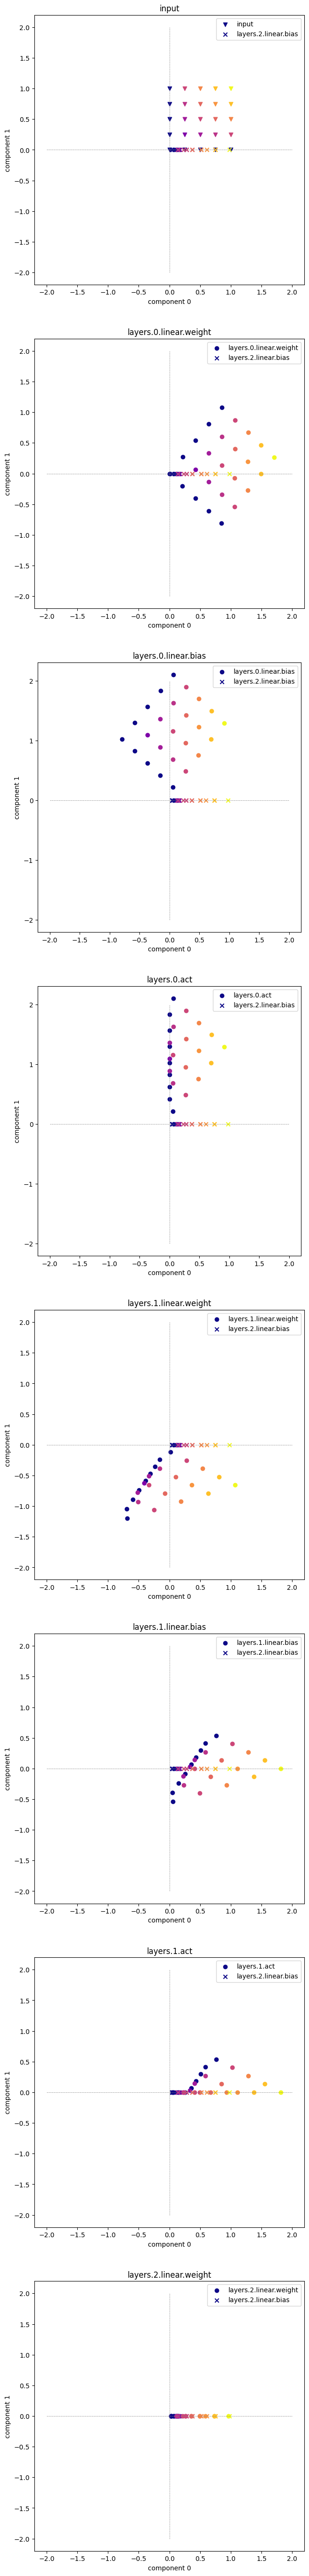

In [34]:
plot_subsets()

Ok, this leads me to an interesting point.

Firstly, we have an algorithm here that is using "tools" that we saw in the 1 hidden layer case e.g. using linear transformations to align with axes to then "project" a subset of the values onto an axis with the ReLU.

If we look at the operation to go from `layers.1.act` to `layers.2.linear.weight`, we can also see that it's using the same trick of using the "y" axis extent to further distinguish the smaller products from the larger ones.

The training loss looks much more interesting as it seems there are a few phase transitions happening. It might be interesting to examine these 🤔

**Please see where this experiment has led me in the main experiment README**

In [21]:
# torch.save(model.state_dict(), 'models/e-1-3375707384.pth')